# Walkthrough: Developing a custom model in the pipeline

Mateusz Wasilewski

Lee Lancashire

Every Cure

16 December 2024. 

# Introduction

The purpose of this notebook is to show how a new, sample model with custom dependencies would be developed and integrated into the pipeline.

This notebook follows a hypothetical scenario where Machine Learning Engineer Maya is developing a new model, with the aim of generating her own predictions of drug-disease treatment efficacy scores. Maya is new to the EveryCure / Matrix ecosystem, and is learning as she goes.

In the end, she wants to train and submit a new model to the pipeline, and have it evaluated along with the other models.

## Modelling assumptions

Maya's goal is to train a new model that will predict the efficacy of drug-disease interactions.

**Embeddings from Knowledge Graph:** Maya knows that EveryCure has generated embeddings for biomedical knowledge graph nodes, which meaningfully encode semantics of the nodes. Many of those nodes are drugs and diseases between which she wants to predict treatment efficacy.

**Training Data:** Maya expects the training data to be a set of known positives and negatives, i.e. drug-disease pairs for which the treatment is known to be effective or ineffective.

**Evaluation:** Maya assumes that the model will be evaluated using AUC-ROC. She also assumes that she will need to perform train-validation splits on her data, and that Matrix's pipeline downstream will be able to further test the predictions of her model.

**Retrieving Data:** Importantly, Maya will retrieve the embeddings and training data from pipelines other than the modelling pipeline. She will avoid preprocessing the data itself as much as possible, relying on other resources provided by EveryCure.


# Prerequesites

Maya needs access to the GCS bucket containing the data (currently, `gs://mtrx-us-central1-hub-dev-storage`). Maya could retrieve those data sources manually from the bucket, using tools such as `gsutil`, but a much better way is to use Kedro's API.

## Dev Environment

Maya will build her prototype in Jupyter Kedro Lab. It is a standard jupyter lab, but with kedro context loaded into the notebook. To run kedro notebooks, using cloud environment (to have access to datasets in the cloud), Maya will run the command:

```
kedro jupyter notebook --env cloud
```

Importantly, she also set her `RELEASE_VERSION` in her `.env` file to `v0.2.4-rc.1`. She chose this release arbitrarily.

Now, Maya will have access to Kedro datasets via Kedro API. For a full tutorial for Kedro API, see [the official documentation](https://docs.kedro.org/en/stable/notebooks_and_ipython/kedro_and_notebooks.html)

Importantly, Kedro catalog object can be retrieved only if the notebook is executed in the root directory of a Kedro project (for Matrix that would be `matrix/pipelines/matrix/my_notebook.ipynb`). If this notebook is executed in the walkthough directory, it might not run properly.

In [7]:
%load_ext kedro.ipython
%reload_kedro  --env cloud
cat = catalog #just a convenience

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[12/18/24 11:11:05] INFO     Resolved project path as: /Users/mpw/Code/matrix/pipelines/matrix.     ]8;id=117836;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=457907;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#171\171]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[12/18/24 11:11:06] INFO     Remembering context for spark later                                       ]8;id=405958;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=494826;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#162\162]8;;\

                    INFO     experiment already exists, re-using                                       ]8;id=865313;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=682910;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#104\104]8;;\

                    INFO     run already exists, re-using                                               ]8;id=97016;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=152598;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#82\82]8;;\

                    INFO     Registering new custom resolver: 'km.random_name'                    ]8;id=27271;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=729074;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#64\64]8;;\

                    WARNING  The mlflow run 9d1df3e0a34644e794c9ed66ebbc5e8e is already active.   ]8;id=40271;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=478406;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#96\96]8;;\
                             Configuration is inferred from the environment, and mlflow.yml is                     
                             ignored.                                                                              

                    WARNING  mlflow_config.server.mlflow_tracking_uri='http://127.0.0.1:5001'    ]8;id=524279;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=601921;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#104\104]8;;\

                    WARNING  mlflow_config.tracking.run.id='9d1df3e0a34644e794c9ed66ebbc5e8e'    ]8;id=253445;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=345804;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#107\107]8;;\

                    WARNING  mlflow_config.tracking.experiment.name='20240807'                   ]8;id=543796;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=733574;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro_mlflow/framework/hooks/mlflow_hook.py#112\112]8;;\

                    INFO     Kedro project matrix                                                   ]8;id=94989;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=405311;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=307670;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=889060;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#142\142]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=514615;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=502111;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#148\148]8;;\

In [8]:
context


KedroContext(
    project_path=PosixPath('/Users/mpw/Code/matrix/pipelines/matrix'),
    config_loader=OmegaConfigLoader(conf_source=/Users/mpw/Code/matrix/pipelines/matrix/conf, env=cloud, config_patterns={'catalog': ['catalog*', 'catalog*/**', '**/catalog*'], 'parameters': <BoxList: ['parameters*', 'parameters*/**', '**/parameters*', '**/parameters*/**']>, 'credentials': ['credentials*', 'credentials*/**', '**/credentials*'], 'globals': <BoxList: ['globals*', 'globals*/**', '**/globals*']>, 'spark': <BoxList: ['spark*', 'spark*/**']>, 'mlflow': <BoxList: ['mlflow*', 'mlflow*/**']>}),
    env='cloud',
    _package_name=None,
    _hook_manager=<pluggy._manager.PluginManager object at 0x30ea5fbd0>,
    _extra_params=None
)

In [9]:
catalog.list("^embeddings.")


[
    'embeddings.feat.bucketized_nodes@spark',
    'embeddings.feat.bucketized_nodes@partitioned',
    'embeddings.feat.graph.node_embeddings@partitioned',
    'embeddings.feat.graph.node_embeddings@spark',
    'embeddings.feat.graph.pca_node_embeddings',
    'embeddings.feat.graph.edges_for_topological',
    'embeddings.tmp.input_nodes',
    'embeddings.tmp.input_edges',
    'embeddings.models.topological',
    'embeddings.model_output.topological',
    'embeddings.feat.nodes',
    'embeddings.reporting.loss',
    'embeddings.reporting.topological_pca',
    'embeddings.reporting.topological_pca_plot'
]


## Required data sources

### Embeddings 

Maya will use the embeddings generated by the Knowledge Graph pipeline to encode the drugs and disease into a vector space.

In the embeddings pipeline, embeddings are extracted from Neo4j and saved to GCS. The pipeline is defined in the [embeddings pipeline](https://github.com/matrix-ml/matrix/blob/main/pipelines/matrix/src/matrix/pipelines/embeddings/pipeline.py). 

```python
node(
    func=nodes.extract_node_embeddings,
    inputs={
        "nodes": "embeddings.model_output.graphsage",
        "string_col": "params:embeddings.write_topological_col",
    },
    outputs="embeddings.feat.nodes",
    name="extract_nodes_edges_from_db",
    tags=[
        "argowf.fuse",
        "argowf.fuse-group.topological_embeddings",
        "argowf.template-neo4j",
    ],
),
```

Kedro Dataset to which the embeddings are saved: 

```yml
embeddings.feat.nodes:
  <<: *_spark_parquet
  filepath: ${globals:paths.embeddings}/feat/nodes_with_embeddings
```


Maya knows that `${globals:paths.embeddings}/feat/nodes_with_embeddings` converts to `gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings`, and this is where that dataset will be available in GCP. However, a much easier way to retrieve it is via kedro catalog.


In [10]:
catalog.datasets.embeddings__feat__nodes

In [11]:
embeddings_spark = catalog.load("embeddings.feat.nodes")

[12/18/24 11:11:12] INFO     Loading data from embeddings.feat.nodes                            ]8;id=308844;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=908055;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\
                             (SparkDatasetWithBQExternalTable)...                                                  

                    WARNING  we are killing spark to create a fresh one                                ]8;id=394154;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=304020;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#130\130]8;;\

                    INFO     Executing for enviornment: cloud                                          ]8;id=553048;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=15301;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#145\145]8;;\

                    INFO     With ARGO_POD_UID set to:                                                 ]8;id=796292;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=35241;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#146\146]8;;\

                    INFO     Thus determined not to be in k8s cluster and executing with               ]8;id=134386;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py\hooks.py]8;;\:]8;id=458346;file:///Users/mpw/Code/matrix/pipelines/matrix/src/matrix/hooks.py#147\147]8;;\
                             service-account.json file                                                             

In [12]:
embeddings_spark

DataFrame[<id>: bigint, <labels>: array<string>, topological_embedding: array<float>, pca_embedding: array<double>, id: string, category: string]

### Ground truth data

Maya needs to retrieve the training data from the preprocessing pipeline, containing True / False positives and negatives that she can use to train her model on the previously retrieved embeddings. First input to other modelling pipelines is `modelling.raw.ground_truth.positives@spark`, so Maya will retrieve that dataset first (together with its negative counterpart `modelling.raw.ground_truth.negatives@spark`).

```python
node(
    func=nodes.create_int_pairs,
    inputs=[
        "embeddings.feat.nodes",
        "modelling.raw.ground_truth.positives@spark",
        "modelling.raw.ground_truth.negatives@spark",
    ],
    outputs="modelling.int.known_pairs@spark",
    name="create_int_known_pairs",
),
```

We retrieve ground truth data (conflated True Positives and True Negatives) from GCS. Both were produced by the `preprocessing` pipeline, as dataset `modelling.raw.ground_truth.positives@pandas` and `modelling.raw.ground_truth.negatives@pandas`, and will be read in as `@spark` dataframes by modelling steps. Maya will run the command below to copy the data to her local machine. Like in the previous step, the used version is arbitrary.

Maya sees that other files live alongside the `*_conflated.tsv` files, and decides to download and investigate them.

In [13]:
ground_truths_positives = catalog.load("modelling.raw.ground_truth.positives@spark")
ground_truths_negatives = catalog.load("modelling.raw.ground_truth.negatives@spark")

[12/18/24 11:11:21] INFO     Loading data from modelling.raw.ground_truth.positives@spark       ]8;id=597654;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=452793;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\
                             (SparkDataset)...                                                                     

[12/18/24 11:11:26] INFO     Loading data from modelling.raw.ground_truth.negatives@spark       ]8;id=703070;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=339290;file:///Users/mpw/Code/matrix/pipelines/matrix/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\
                             (SparkDataset)...                                                                     

# Preprocessing

By now, Maya has obtained the embeddings and ground truth data. She will now preprocess the data to create the input for her model. She will also need to create splits for cross-validation.

Maya will first inspect the ground truth data.

In [14]:
ground_truths_positives_df = ground_truths_positives.toPandas()
ground_truths_negatives_df = ground_truths_negatives.toPandas()

In [15]:
# True positives
ground_truths_positives_df.head()

,source,target
0,CHEBI:3699,MONDO:0007186
1,UNII:84H8Z9550J,MONDO:0007186
2,CHEBI:7915,MONDO:0007186
3,CHEBI:6375,MONDO:0007186
4,CHEBI:33130,MONDO:0007186


In [16]:
# True negatives
ground_truths_negatives_df.head()

,source,target
0,CHEBI:32149,MONDO:0006807
1,CHEBI:32588,MONDO:0006807
2,CHEBI:6804,MONDO:0007186
3,CHEBI:8094,MONDO:0007186
4,CHEMBL.COMPOUND:CHEMBL1187846,MONDO:0007186


True positives and true negatives are represented as sets of source-target pairs. `source` is the drug, `target` is the disease.

Maya will not be loading entire PySpark dataframe with embedding to memory - before conducting an EDA, she wants to reduce unnecessary columns.

She also wants to see what biolink categories the embeddings might have.

In [17]:
from pyspark.sql.functions import col

# Get unique values from the "category" column
unique_categories = embeddings_spark.select(col("category")).distinct()

# Collect unique values to a list (will bring data to the driver)
unique_values = [row["category"] for row in unique_categories.collect()]

unique_values


[
    'biolink:AnatomicalEntity',
    'biolink:Drug',
    'biolink:ChemicalEntity',
    'biolink:SequenceVariant',
    'biolink:Gene',
    'biolink:Pathway',
    'biolink:Polypeptide',
    'biolink:Protein',
    'biolink:MolecularActivity',
    'biolink:GrossAnatomicalStructure',
    'biolink:DiseaseOrPhenotypicFeature',
    'biolink:PhysiologicalProcess',
    'biolink:Disease',
    'biolink:NucleicAcidEntity',
    'biolink:PhenotypicFeature',
    'biolink:BiologicalProcess',
    'biolink:GeneFamily',
    'biolink:Transcript',
    'biolink:CellularComponent',
    'biolink:ChemicalMixture',
    'biolink:MolecularMixture',
    'biolink:MolecularEntity',
    'biolink:Cell',
    'biolink:OrganismTaxon',
    'biolink:CellLine',
    'biolink:SmallMolecule',
    'biolink:Food',
    'biolink:BiologicalEntity',
    'biolink:BehavioralFeature',
    'biolink:RNAProduct',
    'biolink:Behavior',
    'biolink:Vitamin',
    'biolink:BiologicalProcessOrActivity',
    'biolink:NoncodingRNAProduct',
 

## Preprocess embeddings


At first, Maya (a) removed all pca_embeddings, (b) removed all entities which are not drugs or diseases.

In [18]:
from pyspark.sql import functions as F

# Define the categories to keep
categories_to_keep = {
    "biolink:DiseaseOrPhenotypicFeature", 
    "biolink:Drug", 
    "biolink:Disease", 
    "biolink:BehavioralFeature", 
    "biolink:SmallMolecule", 
    "biolink:PhenotypicFeature"
}

# Filter the PySpark DataFrame
filtered_df = embeddings_spark.filter(F.col("category").isin(*categories_to_keep)) \
    .select("topological_embedding", "id") \
    .na.drop(subset=["id", "topological_embedding"])

# Convert the filtered PySpark DataFrame to a Pandas DataFrame
embeddings_df = filtered_df.toPandas()

`filtered_embeddings_path` now contains topological embeddings of drugs and diseases.

Maya filters down the ground truths to a simple list of node ids, to create training data for her model.

In [19]:
ground_truth_ids = set(ground_truths_negatives_df["target"].unique()) | set(ground_truths_negatives_df["source"].unique()) | set(ground_truths_positives_df["target"].unique()) | set(ground_truths_positives_df["source"].unique())


In [20]:
embeddings_df.head()

,topological_embedding,id
0,"[-0.030589668, 0.10044213, 0.19094326, 0.16870...",ATC:L01XY01
1,"[-0.008864332, -0.022826852, 0.056452665, 0.07...",ATC:A10BD14
2,"[-0.0649597, 0.020033212, 0.106236674, 0.15575...",ATC:G03AA11
3,"[0.014651415, 0.009964101, 0.05925943, 0.06414...",ATC:C09DX02
4,"[-0.015761247, -0.045603417, 0.102571644, 0.13...",ATC:J05AP51


In [21]:
# calculate how many ground truths ids have an embedding

len(ground_truth_ids.intersection(embeddings_df["id"].unique())) / len(ground_truth_ids)


0.9672624018707199

In [22]:
df_tn_filtered = ground_truths_negatives_df[ground_truths_negatives_df["target"].isin(embeddings_df["id"]) & ground_truths_negatives_df["source"].isin(embeddings_df["id"])]
df_tp_filtered = ground_truths_positives_df[ground_truths_positives_df["target"].isin(embeddings_df["id"]) & ground_truths_positives_df["source"].isin(embeddings_df["id"])]

In [23]:
# check how many of the ground truth pairs are left
(len(df_tn_filtered) + len(df_tp_filtered)) / (len(ground_truths_negatives_df) + len(ground_truths_positives_df))


0.9346806918015995

Maya filtered down the dataset to 3GB from 24GB, and reduced it to only relevant drugs and diseases. 97% of drugs and diseases from the ground truth data are included in the filtered embeddings, which is satisfactory.

Now, she can proceed to creating her model. 

- `embeddings_df` is the filtered embeddings plus node ids
- `df_tn_filtered` and `df_tp_filtered` are the ground truth data, filtered down to only include rows with a drug and disease that have an embedding


## Prepare data for modelling

Maya combines the filtered embeddings with the ground truth data to create a dataset for model training. She concatenates true positives and negatives, adding a label column.


In [24]:
import pandas as pd

In [25]:
# Concatenate true positives and negatives, adding label column
df_model = pd.concat([
    df_tp_filtered.assign(label=1),
    df_tn_filtered.assign(label=0)
]).reset_index(drop=True)

# Join with embeddings to get source and target embeddings
df_model = (
    df_model
    .merge(
        embeddings_df[['id', 'topological_embedding']],
        left_on='source',
        right_on='id',
        how='left'
    )
    .drop('id', axis=1)
    .rename(columns={'topological_embedding': 'source_embedding'})
    .merge(
        embeddings_df[['id', 'topological_embedding']], 
        left_on='target',
        right_on='id',
        how='left'
    )
    .drop('id', axis=1)
    .rename(columns={'topological_embedding': 'target_embedding'})
)

print(f"Final dataset shape: {df_model.shape}")
df_model.head()


Final dataset shape: (47450, 5)


,source,target,label,source_embedding,target_embedding
0,CHEBI:3699,MONDO:0007186,1,"[0.1749186, 0.43398678, 0.7452298, 0.65872484,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
1,UNII:84H8Z9550J,MONDO:0007186,1,"[0.01990571, -0.08038043, 0.20040062, 0.161179...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
2,CHEBI:7915,MONDO:0007186,1,"[0.07026903, 0.65059316, 0.7452017, 0.7127575,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
3,CHEBI:6375,MONDO:0007186,1,"[-0.02374817, 0.30726308, 0.9234296, 1.0461868...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
4,CHEBI:33130,MONDO:0007186,1,"[0.24461012, 0.22785787, -0.19872648, 0.362895...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."


## Prepare Dataframe with all drug-disease pairs

Maya creates a cartesian product of all unique drugs and diseases to generate every possible drug-disease combination that needs a prediction. This creates a comprehensive matrix of all possible pairs, regardless of whether they were in the training data or not.

The resulting matrix (shown in the heatmap) allows for easy visualization of predicted relationships across the entire drug-disease space.

The code shows that this creates a large number of pairs (number of unique drugs × number of unique diseases), which is why Maya later implements batch processing to handle the predictions efficiently.


In [26]:
# Get unique diseases from both dataframes
all_diseases = pd.concat([
    df_tn_filtered["target"],
    df_tp_filtered["target"]
]).dropna().unique()

# Get unique drugs from both dataframes 
all_drugs = pd.concat([
    df_tn_filtered["source"],
    df_tp_filtered["source"]
]).dropna().unique()

print(f"Number of unique diseases: {len(all_diseases)}")
print(f"Number of unique drugs: {len(all_drugs)}")

Number of unique diseases: 3251
Number of unique drugs: 2456


In [27]:
# Create all possible combinations of drugs and diseases
all_pairs = pd.DataFrame(
    [(drug, disease) for drug in all_drugs for disease in all_diseases],
    columns=['source', 'target']
)

print(f"Total number of drug-disease pairs: {len(all_pairs):,}")
print(f"Shape of all pairs dataframe: {all_pairs.shape}")
all_pairs.head()


Total number of drug-disease pairs: 7,984,456
Shape of all pairs dataframe: (7984456, 2)


,source,target
0,CHEBI:32149,MONDO:0006807
1,CHEBI:32149,MONDO:0007186
2,CHEBI:32149,MONDO:0003781
3,CHEBI:32149,MONDO:0012586
4,CHEBI:32149,MONDO:0013146


## Prepare features dataset


Maya prepares features by converting embeddings into numpy arrays and concatenating them to form input features for the model.

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score


def prepare_features(df):
    # Convert list embeddings to numpy arrays
    source_embeddings = np.vstack(df['source_embedding'].values)
    target_embeddings = np.vstack(df['target_embedding'].values)
    
    # Concatenate the embeddings horizontally
    return np.hstack([source_embeddings, target_embeddings])

# Prepare features
X = prepare_features(df_model)
y = df_model['label'].values

### Create Train / Test split

Maya splits the data into training and test sets, ensuring an 80/20 split, and stratifies the data based on labels.


In [29]:
# First, create a train/test split
from sklearn.model_selection import train_test_split

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training

Maya uses logistic regression for model training, performing cross-validation to evaluate the model's performance on the training data.

In [30]:
# Setup cross-validation on training data only
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
)

# Perform cross-validation on training data
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Print cross-validation results
print("Cross-validation results (on training data):")
print(f"CV scores: {cv_scores}")
print(f"Mean AUC-ROC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



Cross-validation results (on training data):
CV scores: [0.92360492 0.92592707 0.92617956 0.92444715 0.92397456]
Mean AUC-ROC: 0.925 (+/- 0.002)


In [31]:
# Train final model on all training data
final_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
)
trained_model = final_model.fit(X_train, y_train)

# Evaluation

Maya evaluates the trained model on a held-out test set, calculating the AUC-ROC to assess its performance.


In [32]:
# Evaluate on held-out test set
test_predictions = trained_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nFinal model performance on test set:")
print(f"Test AUC-ROC: {test_auc:.3f}")


Final model performance on test set:
Test AUC-ROC: 0.924


## Produce model predictions

Maya generates efficacy score predictions for all possible drug-disease pairs using a batching function to handle large data efficiently.

In [33]:
trained_model

LogisticRegression(max_iter=1000, random_state=42)

Now Maya wants to generate efficacy score predictions for all drug-disease pairs. To avoid fitting all embedidngs in memory, she creates a batching function.

In [34]:
def batch_pairs_with_embeddings(all_pairs, embeddings_df, batch_size=10000):
    """
    Generate batches of drug-disease pairs with their embeddings.
    
    Args:
        all_pairs (pd.DataFrame): DataFrame with 'source' and 'target' columns
        embeddings_df (pd.DataFrame): DataFrame with 'id' and 'topological_embedding' columns
        batch_size (int): Number of pairs to process in each batch
        
    Yields:
        np.array: Array of concatenated source and target embeddings for the batch
        pd.DataFrame: Corresponding batch of pairs
    """
    # Create embeddings lookup dictionary for faster access
    embeddings_dict = dict(zip(embeddings_df['id'], embeddings_df['topological_embedding']))
    
    # Process pairs in batches
    for start_idx in range(0, len(all_pairs), batch_size):
        end_idx = min(start_idx + batch_size, len(all_pairs))
        batch_pairs = all_pairs.iloc[start_idx:end_idx]
        
        # Get embeddings for the batch
        source_embeddings = np.vstack([
            embeddings_dict[source] for source in batch_pairs['source']
        ])
        target_embeddings = np.vstack([
            embeddings_dict[target] for target in batch_pairs['target']
        ])
        
        # Concatenate embeddings
        batch_features = np.hstack([source_embeddings, target_embeddings])
        
        yield batch_features, batch_pairs

# Example usage:
def predict_all_pairs(model, all_pairs, embeddings_df, batch_size=10000):
    """
    Generate predictions for all drug-disease pairs.
    
    Args:
        model: Trained model with predict_proba method
        all_pairs (pd.DataFrame): DataFrame with all drug-disease pairs
        embeddings_df (pd.DataFrame): DataFrame with embeddings
        batch_size (int): Batch size for processing
        
    Returns:
        pd.DataFrame: Original pairs with prediction scores
    """
    all_predictions = []
    all_processed_pairs = []
    
    for batch_features, batch_pairs in batch_pairs_with_embeddings(all_pairs, embeddings_df, batch_size):
        # Get predictions for the batch
        batch_predictions = model.predict_proba(batch_features)[:, 1]
        
        # Store results
        batch_results = batch_pairs.copy()
        batch_results['prediction_score'] = batch_predictions
        all_processed_pairs.append(batch_results)
            
    # Combine all results
    final_results = pd.concat(all_processed_pairs, ignore_index=True)
    return final_results

In [35]:
# Generate predictions
results_df = predict_all_pairs(
    model=trained_model,
    all_pairs=all_pairs,
    embeddings_df=embeddings_df,
    batch_size=50000
)

# View results
print(f"Generated predictions for {len(results_df):,} pairs")
print("\nSample predictions:")
print(results_df.sort_values('prediction_score', ascending=False).head())


Generated predictions for 7,984,456 pairs

Sample predictions:
                source         target  prediction_score
5967538  UMLS:C0456388  UMLS:C1519670               1.0
5968205  UMLS:C0456388  UMLS:C0178874               1.0
6916830  UMLS:C0541491  UMLS:C1519670               1.0
5967539  UMLS:C0456388  UMLS:C0392663               1.0
5967501  UMLS:C0456388  MONDO:0006713               1.0


## Evaluate Prediction Score distributions

Maya visualizes the distribution of prediction scores using histograms and density plots to understand the model's output.

### Test results

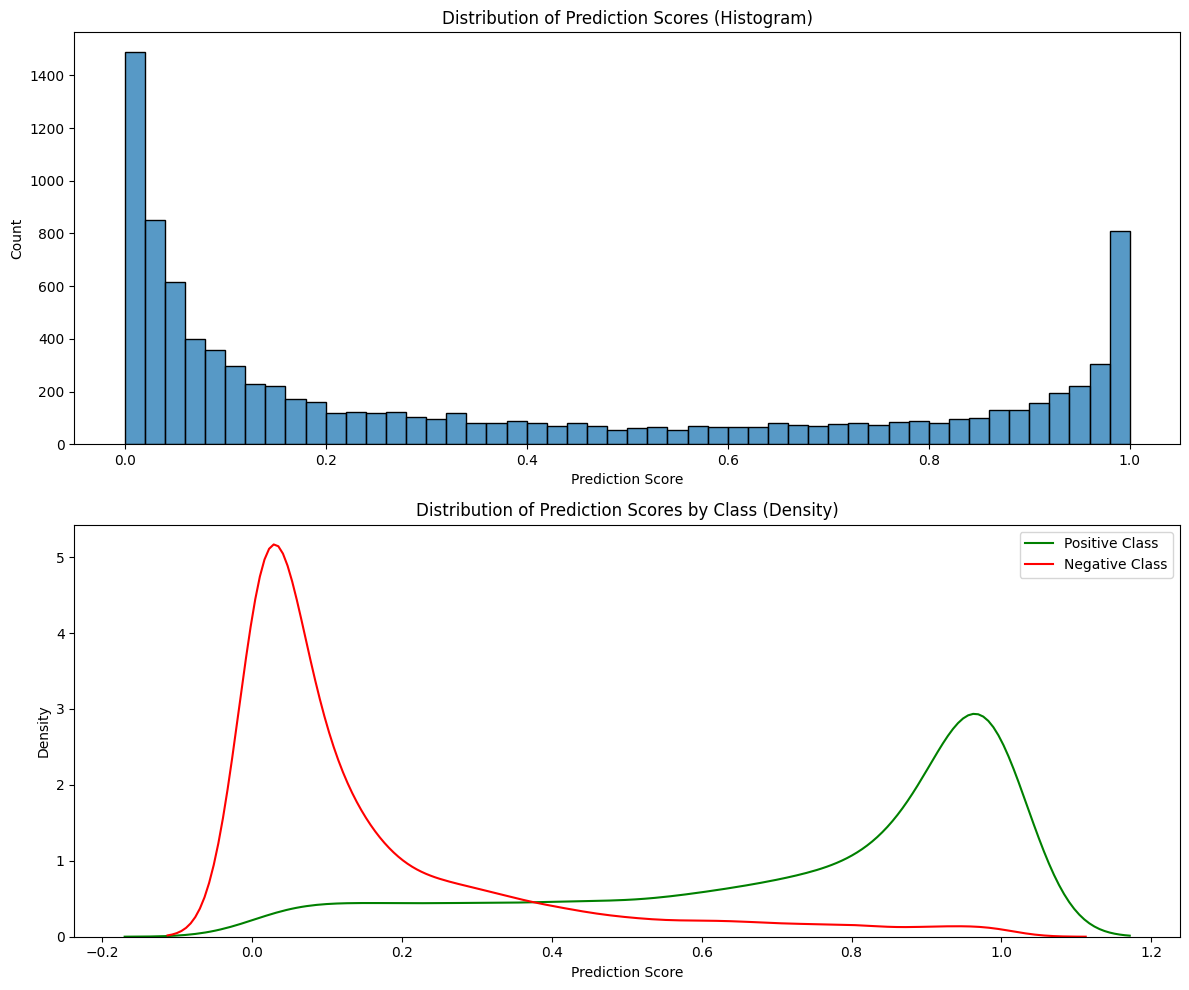


Prediction Score Statistics:
Mean: 0.374
Median: 0.194
Std Dev: 0.373
Min: 0.000
Max: 1.000


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
sns.histplot(
    data=test_predictions,
    bins=50,
    ax=ax1
)
ax1.set_title('Distribution of Prediction Scores (Histogram)')
ax1.set_xlabel('Prediction Score')
ax1.set_ylabel('Count')

# Separate distributions for positive and negative classes
sns.kdeplot(
    data=test_predictions[y_test == 1],
    ax=ax2,
    label='Positive Class',
    color='green'
)
sns.kdeplot(
    data=test_predictions[y_test == 0],
    ax=ax2,
    label='Negative Class',
    color='red'
)
ax2.set_title('Distribution of Prediction Scores by Class (Density)')
ax2.set_xlabel('Prediction Score')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nPrediction Score Statistics:")
print(f"Mean: {test_predictions.mean():.3f}")
print(f"Median: {np.median(test_predictions):.3f}")
print(f"Std Dev: {test_predictions.std():.3f}")
print(f"Min: {test_predictions.min():.3f}")
print(f"Max: {test_predictions.max():.3f}")

## Full Matrix predictions

Maya creates a heatmap to visualize prediction scores for a random sample of drug-disease pairs, providing insights into the model's predictions.


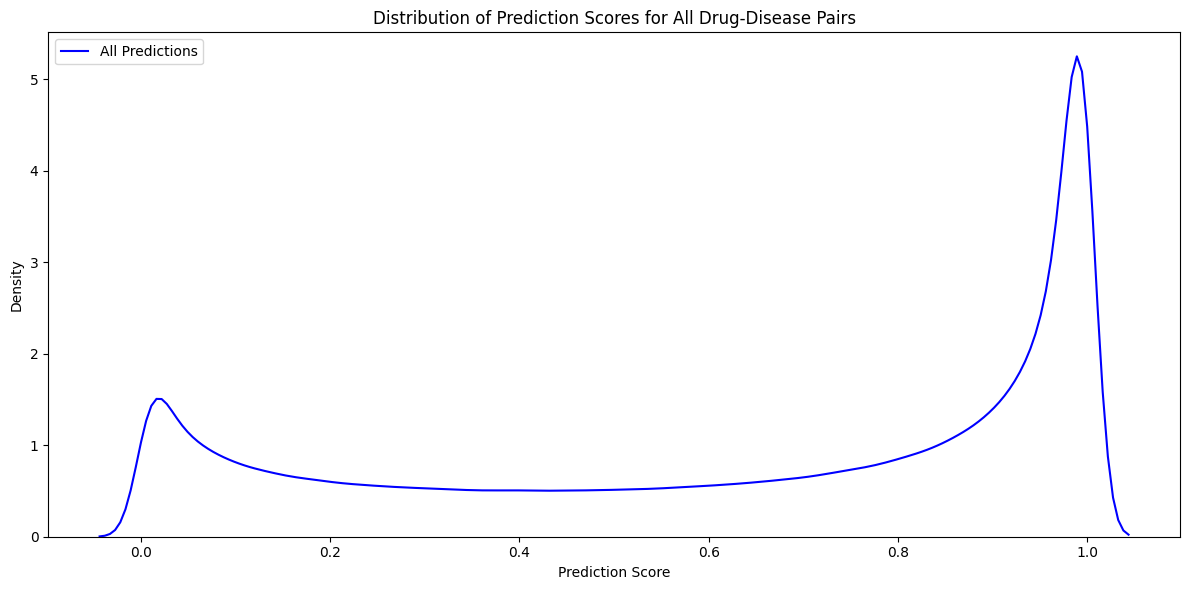


Prediction Score Statistics for All Pairs:
Mean: 0.627
Median: 0.749
Std Dev: 0.350
Min: 0.000
Max: 1.000
Total number of predictions: 7,984,456


In [37]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Overall distribution of all predictions
sns.kdeplot(
    data=results_df['prediction_score'],
    ax=ax,
    label='All Predictions',
    color='blue'
)

ax.set_title('Distribution of Prediction Scores for All Drug-Disease Pairs')
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

# Print basic statistics for all predictions
print("\nPrediction Score Statistics for All Pairs:")
print(f"Mean: {results_df['prediction_score'].mean():.3f}")
print(f"Median: {results_df['prediction_score'].median():.3f}")
print(f"Std Dev: {results_df['prediction_score'].std():.3f}")
print(f"Min: {results_df['prediction_score'].min():.3f}")
print(f"Max: {results_df['prediction_score'].max():.3f}")
print(f"Total number of predictions: {len(results_df):,}")

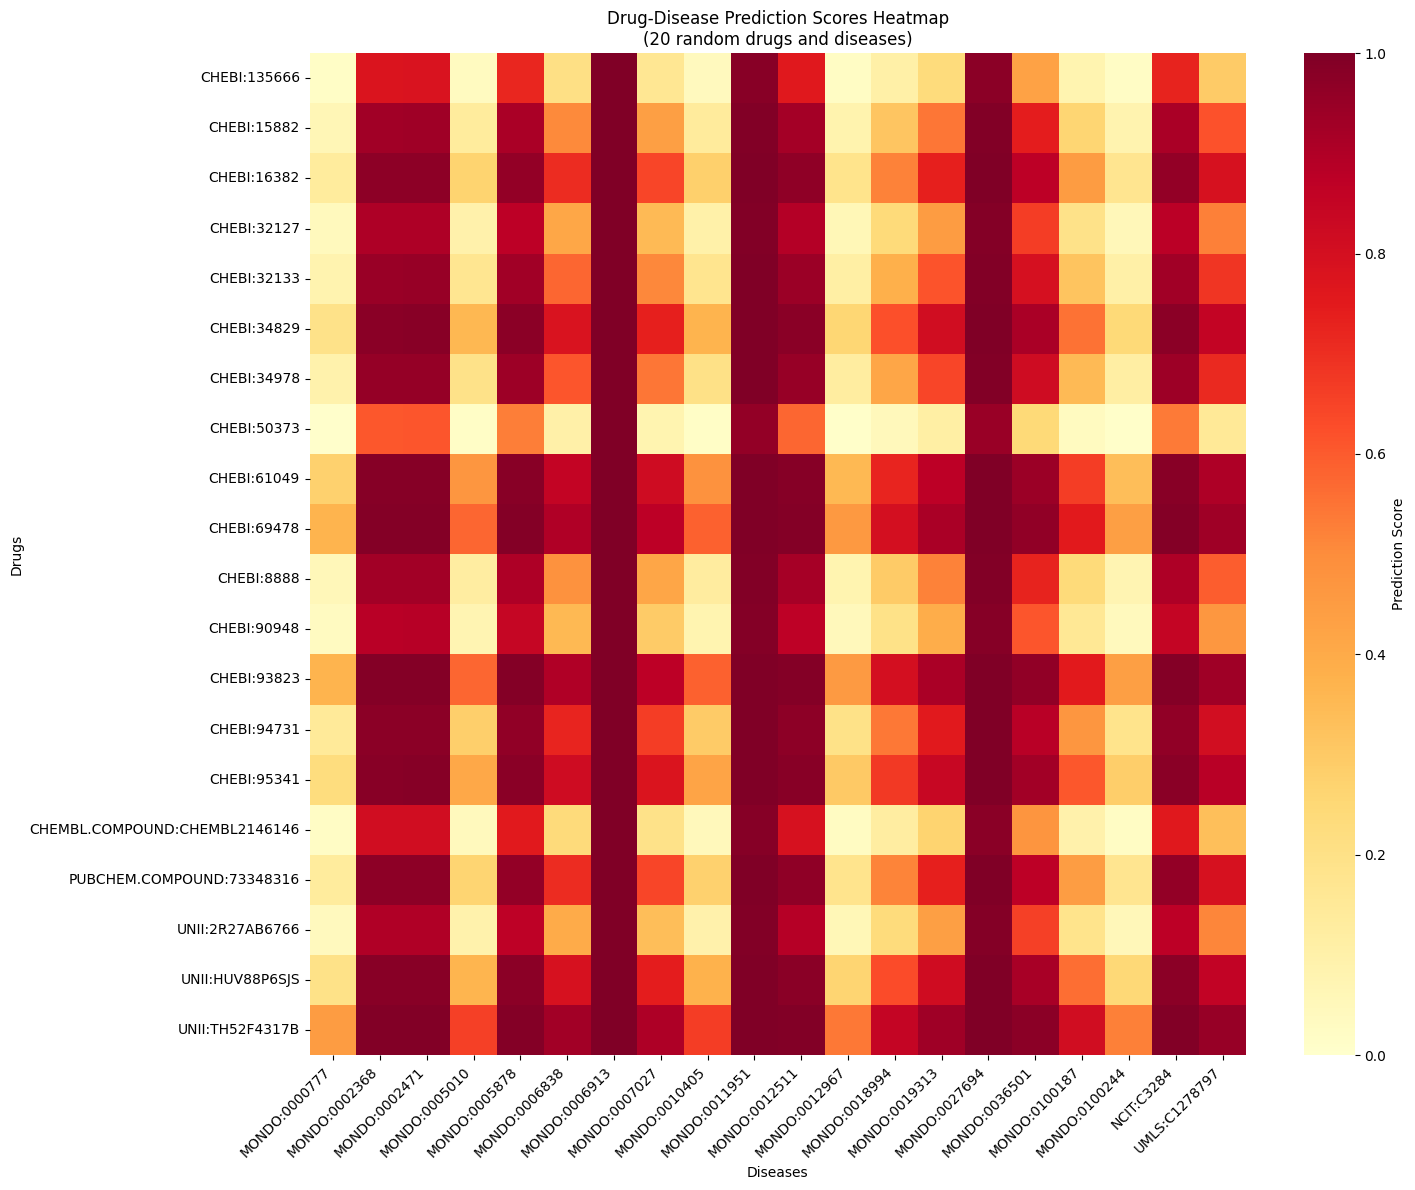


Sample Prediction Statistics:
Mean: 0.634
Median: 0.753
Std Dev: 0.346


In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Randomly sample 20 drugs and 20 diseases
np.random.seed(42)
sample_drugs = np.random.choice(all_drugs, size=20, replace=False)
sample_diseases = np.random.choice(all_diseases, size=20, replace=False)

# Filter results for sampled drugs and diseases
sample_results = results_df[
    results_df['source'].isin(sample_drugs) & 
    results_df['target'].isin(sample_diseases)
]

# Create prediction matrix
pred_matrix = sample_results.pivot(
    index='source', 
    columns='target', 
    values='prediction_score'
)

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    pred_matrix,
    cmap='YlOrRd',
    center=0.5,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Prediction Score'}
)
plt.title('Drug-Disease Prediction Scores Heatmap\n(20 random drugs and diseases)')
plt.xlabel('Diseases')
plt.ylabel('Drugs')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print some statistics about the sampled predictions
print("\nSample Prediction Statistics:")
print(f"Mean: {sample_results['prediction_score'].mean():.3f}")
print(f"Median: {sample_results['prediction_score'].median():.3f}")
print(f"Std Dev: {sample_results['prediction_score'].std():.3f}")

## Evaluation conclusion

Maya generated a full matrix of drug-disease treatment efficacy scores.

We already can see that the model is far from perfect, and it highlights some of the issues our more advanced models has ran into - many drugs and diseases are "frequent flyers" with consistently high scores all across the board. She can also see that many too many drugs-disease pairs have treat scored close to 1.

However, her model is only a basic logistic regression, and for the sake of this exercise we will not be focusing on improving the results she's obrained. 

Now Maya will add her new model as Kedro node.





# Integrating model with Kedro

Now that Maya has created and prototyped her model, she wants to integrate it with EveryCure's Matrix repository, train and run it as part of the `matrix` pipeline.

### Integration with Kedro Pipeline

1. **Pipeline Overview**:
   - Data is prepared and preprocessed in `raw`, `kg_raw`, `ingestion`, `integration`, and `embeddings` pipelines.
   - These datasets are consumed by downstream `modelling`, `evaluation`, `matrix_generation`, and `inference` pipelines.
   - Kedro handles many steps automatically, such as sharding and using ApacheSpark datasets.

2. **Model Configuration**:
   - Models are injected into the Kedro pipeline via dependency injection mechanism.
   - Maya adds her model to `DYNAMIC_PIPELINES_MAPPING` in `pipelines/matrix/src/matrix/settings.py`:

   ```python
   DYNAMIC_PIPELINES_MAPPING = {
       "modelling": [
           {"model_name": "xg_baseline", "num_shards": 1, "run_inference": False},
           {"model_name": "xg_ensemble", "num_shards": 3, "run_inference": True},
           {"model_name": "rf", "num_shards": 1, "run_inference": False},
           {"model_name": "xg_synth", "num_shards": 1, "run_inference": False},
           {"model_name": "mayas_logistic_regression", "num_shards": 1, "run_inference": False},
       ],
       "evaluation": [
   ```

3. **Model Parameters**:
   - Configure parameters in `pipelines/matrix/conf/base/modelling/parameters/mayas_logistic_regression.yml`:

   ```yml
   modelling.mayas_logistic_regression:
       _overrides:
         model_tuning_args:
           tuner:
             object: matrix.pipelines.modelling.tuning.NopTuner
             estimator:
               object: sklearn.linear_model.LogisticRegression
               random_state: ${globals:random_state}
               device: cpu # TODO: Add cuda
           features:
             - source_+
             - target_+
           target_col_name: y
       model_options: ${merge:${.._model_options},${._overrides}}
   ```

   - **Key Points**:
     - The `estimator` is set to `sklearn.linear_model.LogisticRegression`. If she wanted to use an actual custom model object (one she would define and customise), she could reference it's `sklearn`-compliant class here.
     - Uses `NopTuner` for hyperparameter tuning.
     - Those parameters get automatically passed and injected into the model.
     - Following a similar logic, `modelling.<MODEL_NAME>.model_tuning_args` defines parameters for the estimator object. So  all parameters that `sklearn.linear_model.LogisticRegression` eg. `penalty`, `C`, `class_weight`.  etc. could be passed via the config file. For the full list of parameters, have a look at [official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#logisticregression).





## Running model

Now that the model was added to modelling suite, it will be trained and used to generate matrix when the pipeline is executed. The next section describes how she might do this in a notebook to test out the model first. This will then be compatible with the pipeline.

## Custom model

Maya is now interested in creating a custom model that takes the dot product of embeddings and applies a softmax activation. This is her own novel idea that she wants to test out. Since this is a custom model, she will need to take a look in `pipelines/matrix/src/matrix/pipelines/modelling/model.py` and define her own model class.

Maya codes this up into a class called `SumSoftmaxClassifier`. This is compatable with the existing pipeline infrastructure leveraging the `sklearn` interface.

We can now use this as we would any other model by including it in the modelling pipeline and config file as above, replaceing logistic regression with her new model e.g. `mayas_softmax`

In [39]:
from kedro.io import DataCatalog
from kedro.runner import SequentialRunner
from matrix.pipelines.modelling.nodes import (
    attach_embeddings,
    make_splits,
    train_model,
    create_model,
    get_model_predictions,
    check_model_performance
)

We need to load the embeddings using the kedro catalog. 
We already did this earlier in the notebook, so to save time, we will reuse those in this example. 


In [40]:
# 1. Look at embeddings we previously created
embeddings_df


,topological_embedding,id
0,"[-0.030589668, 0.10044213, 0.19094326, 0.16870...",ATC:L01XY01
1,"[-0.008864332, -0.022826852, 0.056452665, 0.07...",ATC:A10BD14
2,"[-0.0649597, 0.020033212, 0.106236674, 0.15575...",ATC:G03AA11
3,"[0.014651415, 0.009964101, 0.05925943, 0.06414...",ATC:C09DX02
4,"[-0.015761247, -0.045603417, 0.102571644, 0.13...",ATC:J05AP51
...,...,...
1459872,"[0.04522865, 0.20245677, -0.030826908, 0.21916...",ttd.target:Quinoline_carboxamide_derivative_1
1459873,"[0.1416671, 0.22784449, 0.07946762, 0.09356948...",ttd.target:SK-NBP601
1459874,"[0.17295104, 0.12946096, 0.06036864, 0.3531766...",ttd.target:Tetra-hydro-triazolopyrimidine_deri...
1459875,"[0.101661295, 0.10240988, 0.222844, 0.20699313...",ttd.target:Triazole_derivative_2


We will also need the training data to create splits- again we will reuse the same data we used previously. 

In [41]:
df_model

,source,target,label,source_embedding,target_embedding
0,CHEBI:3699,MONDO:0007186,1,"[0.1749186, 0.43398678, 0.7452298, 0.65872484,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
1,UNII:84H8Z9550J,MONDO:0007186,1,"[0.01990571, -0.08038043, 0.20040062, 0.161179...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
2,CHEBI:7915,MONDO:0007186,1,"[0.07026903, 0.65059316, 0.7452017, 0.7127575,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
3,CHEBI:6375,MONDO:0007186,1,"[-0.02374817, 0.30726308, 0.9234296, 1.0461868...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
4,CHEBI:33130,MONDO:0007186,1,"[0.24461012, 0.22785787, -0.19872648, 0.362895...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
...,...,...,...,...,...
47445,CHEBI:5959,MONDO:0004981,0,"[0.18785809, 0.39737, 0.6268821, 0.6997055, -0...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47446,UNII:183E4W213W,MONDO:0004981,0,"[0.12992747, 0.054867685, -0.116463006, 0.4809...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47447,CHEBI:27882,MONDO:0004981,0,"[-0.5312017, 0.44113338, 0.8198503, 0.9630272,...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47448,CHEBI:6801,MONDO:0004981,0,"[-0.2729406, 0.039909743, 0.45587704, 0.660389...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."


In [42]:
# Keep the original df_model structure but rename 'label' to 'y'
df_model_prepared = df_model.rename(columns={'label': 'y'})

df_model_prepared

,source,target,y,source_embedding,target_embedding
0,CHEBI:3699,MONDO:0007186,1,"[0.1749186, 0.43398678, 0.7452298, 0.65872484,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
1,UNII:84H8Z9550J,MONDO:0007186,1,"[0.01990571, -0.08038043, 0.20040062, 0.161179...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
2,CHEBI:7915,MONDO:0007186,1,"[0.07026903, 0.65059316, 0.7452017, 0.7127575,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
3,CHEBI:6375,MONDO:0007186,1,"[-0.02374817, 0.30726308, 0.9234296, 1.0461868...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
4,CHEBI:33130,MONDO:0007186,1,"[0.24461012, 0.22785787, -0.19872648, 0.362895...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
...,...,...,...,...,...
47445,CHEBI:5959,MONDO:0004981,0,"[0.18785809, 0.39737, 0.6268821, 0.6997055, -0...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47446,UNII:183E4W213W,MONDO:0004981,0,"[0.12992747, 0.054867685, -0.116463006, 0.4809...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47447,CHEBI:27882,MONDO:0004981,0,"[-0.5312017, 0.44113338, 0.8198503, 0.9630272,...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."
47448,CHEBI:6801,MONDO:0004981,0,"[-0.2729406, 0.039909743, 0.45587704, 0.660389...","[-0.15491335, 0.2701274, -0.67102075, -0.13310..."


The next sections will use the pipeline nodes to train the model, test and evaluate the model 

In [43]:
# 2. Create splits
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.1,
    random_state=42
)

# Create splits using existing df_model
splits = make_splits(
    data=df_model_prepared,
    splitter=splitter
)

In [44]:
splits

,source,target,y,source_embedding,target_embedding,iteration,split
0,CHEBI:3699,MONDO:0007186,1,"[0.1749186, 0.43398678, 0.7452298, 0.65872484,...","[0.44671196, -0.3108637, 0.06650227, -0.133686...",0,TRAIN
1,UNII:84H8Z9550J,MONDO:0007186,1,"[0.01990571, -0.08038043, 0.20040062, 0.161179...","[0.44671196, -0.3108637, 0.06650227, -0.133686...",0,TRAIN
2,CHEBI:7915,MONDO:0007186,1,"[0.07026903, 0.65059316, 0.7452017, 0.7127575,...","[0.44671196, -0.3108637, 0.06650227, -0.133686...",0,TEST
3,CHEBI:6375,MONDO:0007186,1,"[-0.02374817, 0.30726308, 0.9234296, 1.0461868...","[0.44671196, -0.3108637, 0.06650227, -0.133686...",0,TRAIN
4,CHEBI:33130,MONDO:0007186,1,"[0.24461012, 0.22785787, -0.19872648, 0.362895...","[0.44671196, -0.3108637, 0.06650227, -0.133686...",0,TRAIN
...,...,...,...,...,...,...,...
47445,CHEBI:5959,MONDO:0004981,0,"[0.18785809, 0.39737, 0.6268821, 0.6997055, -0...","[-0.15491335, 0.2701274, -0.67102075, -0.13310...",0,TRAIN
47446,UNII:183E4W213W,MONDO:0004981,0,"[0.12992747, 0.054867685, -0.116463006, 0.4809...","[-0.15491335, 0.2701274, -0.67102075, -0.13310...",0,TEST
47447,CHEBI:27882,MONDO:0004981,0,"[-0.5312017, 0.44113338, 0.8198503, 0.9630272,...","[-0.15491335, 0.2701274, -0.67102075, -0.13310...",0,TRAIN
47448,CHEBI:6801,MONDO:0004981,0,"[-0.2729406, 0.039909743, 0.45587704, 0.660389...","[-0.15491335, 0.2701274, -0.67102075, -0.13310...",0,TEST


In [63]:
from importlib import reload
from matrix.pipelines.modelling import model
reload(model)
from matrix.pipelines.modelling.model import DotProductSoftmaxClassifier

In [64]:
# 3. Train the SumSoftmaxClassifier
model = DotProductSoftmaxClassifier(random_state=42)

# The model expects concatenated embeddings
features = ['source_embedding', 'target_embedding']
trained_model = train_model(
    data=splits,
    estimator=model,
    features=features,
    target_col_name='y'
)

In [65]:
# Create final model using create_model function
final_model = create_model(trained_model)  # This wraps it in ModelWrapper


In [66]:
# 4. Get predictions
predictions = get_model_predictions(
    data=splits,
    model=trained_model,
    features=features,
    target_col_name='y'
)

In [67]:
# 5. Check performance

from sklearn.metrics import accuracy_score, f1_score
from matrix.pipelines.modelling.utils import partial_

metrics = {
    'accuracy': accuracy_score,
    'macro_f1': partial_(f1_score, average='macro')
}

# Check performance
performance = check_model_performance(
    data=predictions,
    metrics=metrics,
    target_col_name='y'
)




In [68]:
print("\nModel Performance:")
for metric, value in performance.items():
    print(f"{metric}: {value:.3f}")



Model Performance:
test_accuracy: 0.375
train_accuracy: 0.375
test_macro_f1: 0.273
train_macro_f1: 0.273


The performance of the model is not good, but this is to be expected since it was a simple dot product between embeddings just to show how to integrate a custom model. 
For this to work in the pipeline, we can create a custom pipeline node that takes the embeddings and applies the softmax function. This should follow scikit-learn's interface methods.

For example, within the `pipelines/matrix/src/matrix/pipelines/modelling/model.py` file, we can add a new class:

```python
from sklearn.base import BaseEstimator, ClassifierMixin
from typing import Optional
import pandas as pd
from scipy.special import softmax

class DotProductSoftmaxClassifier(BaseEstimator, ClassifierMixin):
    """A classifier that uses dot product between source and target embeddings.
    
    """

    def __init__(self, random_state: Optional[int] = None):
        self.random_state = random_state

    def _prepare_features(self, X):
        """Convert embeddings from DataFrame or array to numpy array."""
        if isinstance(X, pd.DataFrame):
            # Handle PySpark DataFrame conversion to numpy
            if hasattr(X, 'toPandas'):
                X = X.toPandas()
            
            # Convert source embeddings
            if 'source_embedding' in X.columns:
                source_embeddings = np.vstack([
                    np.array(x) if isinstance(x, list) else x 
                    for x in X['source_embedding']
                ])
                target_embeddings = np.vstack([
                    np.array(x) if isinstance(x, list) else x 
                    for x in X['target_embedding']
                ])
            else:
                # Assume columns are already split into individual features
                source_cols = [col for col in X.columns if col.startswith('source_')]
                target_cols = [col for col in X.columns if col.startswith('target_')]
                source_embeddings = X[source_cols].values
                target_embeddings = X[target_cols].values
                
            return np.hstack([source_embeddings, target_embeddings])
        elif isinstance(X, np.ndarray) and X.dtype == object:
            n_samples = X.shape[0]
            source_embeddings = np.vstack([
                np.array(x) if isinstance(x, list) else x 
                for x in X[:, 0]
            ])
            target_embeddings = np.vstack([
                np.array(x) if isinstance(x, list) else x 
                for x in X[:, 1]
            ])
            return np.hstack([source_embeddings, target_embeddings])
        return X

    def fit(self, X, y):
        """Fit the model."""
        X = self._prepare_features(X)
        self.n_classes_ = len(np.unique(y))
        self.classes_ = np.unique(y)
        self.embedding_dim_ = X.shape[1] // 2
        return self

    def predict_proba(self, X):
        """Compute probabilities using dot product and softmax."""
        X = self._prepare_features(X)
        
        # Split features into source and target embeddings
        source_embeddings = X[:, :self.embedding_dim_]
        target_embeddings = X[:, self.embedding_dim_:]
        
        # Compute dot product
        dot_products = np.sum(source_embeddings * target_embeddings, axis=1)
        
        # Reshape to (n_samples, 2) for binary classification
        scores = np.column_stack([-dot_products, dot_products])
        
        # Apply softmax
        probs = softmax(scores, axis=1)
        
        return probs

    def predict(self, X):
        """Predict class labels."""
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

```



As above, we can also configure parameters in `pipelines/matrix/conf/base/modelling/parameters/mayas_logistic_regression.yml`:

```yml
   modelling.mayas_softmax:
    _overrides:

      model_tuning_args:
        tuner:
          object: matrix.pipelines.modelling.tuning.NopTuner
          estimator:
            object: matrix.pipelines.modelling.model.DotProductSoftmaxClassifier
            random_state: ${globals:random_state}
        features: # Features use regex, source_0, source_1, .., target_0, target_1
          - source_+
          - target_+
        target_col_name: y
      
    # NOTE: This leverages the custom `merge` resolver to override
    # the base options with the override block above.
    model_options: ${merge:${.._model_options},${._overrides}}
```

- Models are injected into the Kedro pipeline via dependency injection mechanism.
   - Maya adds her model to `DYNAMIC_PIPELINES_MAPPING` in `pipelines/matrix/src/matrix/settings.py`:

   ```python
   DYNAMIC_PIPELINES_MAPPING = {
       "modelling": [
           {"model_name": "xg_baseline", "num_shards": 1, "run_inference": False},
           {"model_name": "xg_ensemble", "num_shards": 3, "run_inference": True},
           {"model_name": "rf", "num_shards": 1, "run_inference": False},
           {"model_name": "xg_synth", "num_shards": 1, "run_inference": False},
           {"model_name": "mayas_softmax", "num_shards": 1, "run_inference": False},
       ],
       "evaluation": [
   ```






This can then be run as part of the pipeline. For example to test: 

```bash
kedro run --env test -p test
```


